# 变分推理

- 知识准备
- 变分推理理解
- 变分推理实例：一维高斯分布的后验近似
- 变分推理实例：使用数值解法

## 知识准备

### 高斯分布

对于随机变量 $X$，若其服从均值为 $\mu$、方差为 $\sigma^2$ 的高斯分布，记为 $X \sim \mathcal{N}(\mu, \sigma^2)$，其概率密度函数为：

$$
f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

**参数说明**：
- $\mu$：均值（位置参数），决定分布的中心位置。
- $\sigma^2$：方差（尺度参数），决定分布的离散程度，\( \sigma \) 为标准差。

### 贝叶斯公式

$$
p(z|x) = \frac{p(x|z)p(z)}{p(x)}
$$

### KL 散度公式

KL 散度（Kullback-Leibler Divergence）用于衡量两个概率分布 $P$ 和 $Q$ 的差异，是信息论中的重要概念，**非对称**（即 $\text{KL}(P\|Q) \neq \text{KL}(Q\|P)$）。

#### 离散型分布的 KL 散度
若 $P$ 和 $Q$ 是离散概率分布，定义在样本空间 $\mathcal{X}$ 上，则：

$$
\text{KL}(P\|Q) = \sum_{x \in \mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)
$$

- 当 $P(x) = 0$ 时，对应项为 0；当 $Q(x) = 0$ 且 $P(x) > 0$ 时，KL 散度为无穷大。


#### 连续型分布的 KL 散度
若 $P$ 和 $Q$ 是连续概率密度函数，则：

$$
\text{KL}(P\|Q) = \int_{-\infty}^{+\infty} p(x) \log\left(\frac{p(x)}{q(x)}\right) dx
$$

其中 $p(x)$ 和 $q(x)$ 分别为分布 $P$ 和 $Q$ 的概率密度函数。


### 高斯共轭分布

高斯分布的共轭性质，是指当先验分布 $p(z)$ 和似然函数 $p(x|z)$ 属于同一分布族时，后验分布 $p(z|x)$ 也会属于这个分布族 。在一维高斯分布的场景下，若先验分布是高斯分布，似然函数也是高斯分布，那么后验分布同样是高斯分布。

假设隐变量 $z$ 的先验分布 $p(z)$ 服从均值为 $\mu_0$、方差为 $\sigma_0^2$ 的高斯分布，即 $p(z)=\mathcal{N}(z;\mu_0, \sigma_0^2)$ ；在给定 $z$ 的情况下，观测变量 $x$ 的似然函数 $p(x|z)$ 服从均值为 $z$、方差为 $\sigma_1^2$ 的高斯分布，即 $p(x|z)=\mathcal{N}(x;z, \sigma_1^2)$。

根据贝叶斯公式 $p(z|x) = \frac{p(x|z)p(z)}{p(x)}$ ，通过一系列化简，可以得出后验分布 $p(z|x)$ 也是高斯分布，其均值 $\mu_{post}$ 和方差 $\sigma_{post}^2$ 的计算公式为：
- 均值：$\mu_{post} = \frac{\sigma_1^2 \mu_0 + \sigma_0^2 x}{\sigma_0^2 + \sigma_1^2}$
- 方差：$\sigma_{post}^2 = \frac{\sigma_0^2 \sigma_1^2}{\sigma_0^2 + \sigma_1^2}$


## 变分推理理解

### 为什么需要变分推理

在贝叶斯模型中，我们通常需要计算后验概率 $p(z|x)$：​

$$
p(z|x) = \frac{p(x|z)p(z)}{p(x)} = \frac{p(x|z)p(z)}{\int p(x,z)dz} = \frac{p(x|z)p(z)}{\int p(x|z)p(z)dz}
$$

当隐变量 $z$ 维度高或分布复杂时，分母的积分（边际似然 $\int p(x,z)dz$）难以解析计算。变分推理的思路是：用一个简单的参数化分布 q(z;\theta) 近似真实后验 $p(z|x)$，通过优化参数 $\theta$ 让 $q$ 尽可能接近 $p(z∣x)$。

###  KL 散度与后验近似的目标

KL 散度衡量两个分布的差异，我们希望 $q(z;\theta)$ 和 $p(z|x)$ 两个分布越接近越好，也就是最小化下面的式子：

$$
\begin{aligned}
    KL(q(z;\theta)|p(z|x)) & = \mathbb{E}_q\left[\log\frac{q(z;\theta)}{p(z|x)}\right]  \\
    & = \mathbb{E}_q\left[\log q(z;\theta) - \log p(z|x)\right] \\
    & = \mathbb{E}_q\left[\log q(z;\theta) - \log \frac{p(x,z)}{p(x)} \right], p(z|x) = p(x,z)/p(x) \\
\end{aligned}
$$

但是上面的式子 $KL(q(z;\theta)|p(z|x))$ 中，包含未知的边际似然 $p(x)$，无法直接计算，我们进行以下化简。

### 分解 KL 散度, 引入 ELBO

我们继续化简 $KL(q(z;\theta)|p(z|x))$ 式子：

$$
\begin{aligned}
    KL(q(z;\theta)|p(z|x)) & = \mathbb{E}_q\left[\log q(z;\theta) - \log \frac{p(x,z)}{p(x)} \right] \\
    & = \mathbb{E}_q\left[\log q(z;\theta) - \log p(x,z) + \log p(x) \right] \\
    & = \mathbb{E}_q\left[\log q(z;\theta) - \log p(x,z) \right] + \log p(x) \\
\end{aligned}
$$

我们对上面的式子进行整理，得到以下的式子：

$$
\begin{aligned}
    \log p(x) & = KL(q(z;\theta)|p(z|x)) - \mathbb{E}_q\left[\log q(z;\theta) - \log p(x,z) \right] \\
    & = KL(q(z;\theta)|p(z|x)) + \mathbb{E}_q\left[\log p(x,z) - q(z;\theta) \right] \\
    & = KL(q(z;\theta)|p(z|x)) + \mathbb{E}_{z \sim q} \left[\log \frac{p(x,z)}{q(z;\theta)} \right]
\end{aligned}
$$

经过如上推导，一般通常把 $\mathbb{E}_{z \sim q} \left[\log \frac{p(x,z)}{q(z;\theta)} \right]$ 称为 ELBO (Evidence Lower Bound, 证据下界)。在给定 $x$ 之后，$\log p(x)$ 是一个固定的数值，且 KL 散度非负，于是最小化 $KL(q(z;\theta)|p(z|x))$ 可以转为最大化 ELBO 值。下图给了一个可视化的解释：

<div align=center>
   <img src="./assets/1_vl/max_elbo.png" width="50%" >
</div>

### 理解 ELBO

我们可以将上面的 ELBO 进一步化简：

$$
\begin{aligned}
    ELBO & = \mathbb{E}_{z \sim q} \left[\log \frac{p(x,z)}{q(z;\theta)} \right] \\
    & = \mathbb{E}_{z \sim q} \left[\log \frac{p(x|z) p(z)}{q(z;\theta)} \right], p(x,z)=p(x|z)p(z) \\
    & = \mathbb{E}_{z \sim q} \left[\log p(x|z) + \log p(z) - \log q(z;\theta) \right] \\
    & = \mathbb{E}_{z \sim q} \left[\log p(x|z) \right] - \mathbb{E}_{z \sim q} \left[ KL(q(z;\theta) || p(z)) \right]
\end{aligned}
$$

此时 ELBO 就由两个部分组成，分别是
- $\mathbb{E}_{z \sim q} \left[\log p(x|z) \right]$：衡量了在当前近似后验分布 $p(z|x)$ 下，模型生成观测数据 $x$ 的可能性大小，也就是重构损失；
- $\mathbb{E}_{z \sim q} \left[ KL(q(z;\theta) || p(z)) \right]$：当前变分分布 $q(z;\theta)$ 和分布 $p(z)$ 的匹配情况。这里希望 $q(z;\theta)$ 和 $p(z)$ 分布相似，但又需要考虑前面生成 $x$ 的情况，也就是同时还需要最大化 $\mathbb{E}_{z \sim q} \left[\log p(x|z) \right]$；

## 变分推理实例：一维高斯分布的后验近似

### 模型设定与问题背景

我们构造一个简单的贝叶斯模型，其中：
- 隐变量 $z$ 服从先验分布 $p(z) = \mathcal{N}(z; 0, 1)$（均值为 0，方差为 1 的高斯分布）
- 观测变量 $x$ 在给定 $z$ 时的概率分布为 $p(x|z) = \mathcal{N}(x;z,1)$（均值为 $z$，方差为 1 的高斯分布）

我们希望计算当观测数据 $x=2$ 的时候，使用变分推理的方法近似 $p(z|x=2)$，并与真实的后验进行对比。

### 真实后验分布 p(z|x)

根据高斯分布的共轭性质，后验分布 $p(z|x)$ 也是高斯分布，其参数为：
- 均值：$\mu_{post} = \frac{\sigma_1^2 \mu_0 + \sigma_0^2 x}{\sigma_0^2 + \sigma_1^2}$
- 方差：$\sigma_{post}^2 = \frac{\sigma_0^2 \sigma_1^2}{\sigma_0^2 + \sigma_1^2}$

这里 $\mu_0$ 和 $\sigma_0^2$ 是先验分布的系数，也就是 $\mu_0 = 0$，$\sigma_0^2=1$。$\sigma_1^2$ 是 $p(x|z)$ 的方差，也就是 $\sigma_1^2=1$。于是带入参数 $\mu_0=0, \sigma_0^2=1, \sigma_1^2=1, x=2$，得到：

$$
\mu_{post} = \frac{1 \cdot 0 + 1 \cdot 2}{1 + 1} = 1, \quad \sigma_{post}^2 = \frac{1 \cdot 1}{1 + 1} = 0.5
$$

所以真实的后验分布为 $p(z|x=2) = \mathcal{N}(z; 1, 0.5)$。

### 变分分布假设

我们假设变分分布 $q(z;\theta)$ 为高斯分布，我们使用参数化表示为：

$$
q(z; \mu, \sigma^2) = \mathcal{N}(z; \mu, \sigma^2)
$$

这里待优化的参数为 $\theta = (\mu, \sigma^2)$。

### 根据 ELBO 计算参数

我们根据前面推导的 ELBO 公式，带入已知的分布：
- $p(z) = \mathcal{N}(z; 0, 1)$
- $p(x|z) = \mathcal{N}(x;z,1)$
- $q(z;\theta) = \mathcal{N}(z; \mu, \sigma^2)$

$$
\begin{aligned}
    ELBO & = \mathbb{E}_{z \sim q} \left[\log p(x|z) + \log p(z) - \log q(z;\theta) \right] \\
    & = \mathbb{E}_{z \sim q} \left[\log \mathcal{N}(x;z,1) + \log \mathcal{N}(z; 0, 1) - \log \mathcal{N}(z; \mu, \sigma^2) \right]
\end{aligned}
$$

我们对上面的式子进行化简，分别求出三个期望。首先化简 $\mathbb{E}_{z \sim q} \left[\log \mathcal{N}(x=2; z, 1) \right]$：

$$
\begin{aligned}
    \mathbb{E}_{z \sim q} \left[\log \mathcal{N}(x=2; z, 1) \right] & = -\frac{1}{2}\log(2\pi) - \frac{1}{2}\mathbb{E}_{z \sim q} \left[(2 - z)^2 \right] \\
    & = -\frac{1}{2}\log(2\pi) - \frac{1}{2}\left[(2 - \mu)^2 + \sigma^2 \right]
\end{aligned}
$$

接着化简 $\mathbb{E}_{z \sim q} \left[\log \mathcal{N}(z; 0, 1) \right]$：

$$
\begin{aligned}
    \mathbb{E}_{z \sim q} \left[\log \mathcal{N}(z; 0, 1) \right] & = -\frac{1}{2}\log(2\pi) - \frac{1}{2}\mathbb{E}_{z \sim q} \left[z^2 \right] \\
    & = -\frac{1}{2}\log(2\pi) - \frac{1}{2}\left[\mu^2 + \sigma^2 \right]
\end{aligned}
$$

最后化简 $\mathbb{E}_{z \sim q} \left[\log \mathcal{N}(z; \mu, \sigma^2) \right]$：

$$
\begin{aligned}
    \mathbb{E}_{z \sim q} \left[\log \mathcal{N}(z; \mu, \sigma^2) \right] & = -\frac{1}{2}\log(2\pi\sigma^2) - \frac{1}{2}\mathbb{E}_{z \sim q} \left[(z - \mu)^2 \right] \\
    & = -\frac{1}{2}\log(2\pi\sigma^2) - \frac{1}{2}\sigma^2
\end{aligned}
$$

将上述结果代入 ELBO 表达式：​

$$
\begin{aligned}
    ELBO & = \mathbb{E}_{z \sim q} \left[\log p(x|z) + \log p(z) - \log q(z;\theta) \right] \\
    & = \left[-\frac{1}{2}\log(2\pi) - \frac{1}{2}\left((2 - \mu)^2 + \sigma^2 \right)\right] + \left[-\frac{1}{2}\log(2\pi) - \frac{1}{2}\left(\mu^2 + \sigma^2 \right)\right] - \left[-\frac{1}{2}\log(2\pi\sigma^2) - \frac{1}{2}\sigma^2 \right] \\
    & = -\log(2\pi) - \frac{1}{2}\left((2 - \mu)^2 + \sigma^2 + \mu^2 + \sigma^2 \right) + \frac{1}{2}\log(2\pi\sigma^2) + \frac{1}{2}\sigma^2 \\
    & = -\log(2\pi) + \frac{1}{2}\log(2\pi) + \frac{1}{2}\log(\sigma^2) - \frac{1}{2}\left((2 - \mu)^2 + \mu^2 + \sigma^2 \right) \\
    & = -\frac{1}{2}\log(2\pi) + \frac{1}{2}\log(\sigma^2) - \frac{1}{2}\left(4 - 4\mu + \mu^2 + \mu^2 + \sigma^2 \right) \\
    & = \frac{1}{2}\log(\sigma^2) - \frac{1}{2}\log(2\pi) - \frac{1}{2}\left(4 - 4\mu + 2\mu^2 + \sigma^2 \right)
\end{aligned}
$$

为了最大化 ELBO，对参数 $\mu$ 和 $\sigma^2$ 求偏导并令导数为 0。

1. 首先对 $\mu$ 求偏导：

$$
\frac{\partial ELBO}{\partial \mu} = \frac{1}{2} \cdot 4 - \frac{1}{2} \cdot 4\mu = 2 - 2\mu = 0 \quad \Rightarrow \quad \mu = 1
$$

2. 接着对 $\sigma^2$ 求导（令 $v=\sigma^2$）:

$$
\frac{\partial ELBO}{\partial v} = \frac{1}{2v} - \frac{1}{2} = 0 \quad \Rightarrow \quad v = 1
$$

最优变分分布为 $q(z; \mu=1, \sigma^2=1) = \mathcal{N}(z; 1, 1)$.


In [1]:
# 第一部分：导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

In [2]:
# 第二部分：定义模型参数
# 先验分布 p(z) = N(0, 1)
prior_mean = 0
prior_var = 1

# 似然函数参数 p(x|z) = N(z, 1)
likelihood_var = 1

# 观测值
x_observed = 2.0

In [3]:
# 第三部分：计算真实后验分布参数
# 根据共轭分布理论计算解析解
posterior_mean = (likelihood_var * prior_mean + prior_var * x_observed) / (prior_var + likelihood_var)
posterior_var = (prior_var * likelihood_var) / (prior_var + likelihood_var)

print(f"真实后验分布参数: N(μ={posterior_mean:.2f}, σ²={posterior_var:.2f})")

真实后验分布参数: N(μ=1.00, σ²=0.50)


In [ ]:
# 第四部分：计算最优变分分布参数
# 通过最大化 ELBO 得到的最优参数
variational_mean = 1.0  # 推导得出 μ=1
variational_var = 1.0  # 推导得出 σ²=1

print(f"变分近似分布参数: N(μ={variational_mean:.2f}, σ²={variational_var:.2f})")

变分近似分布参数: N(μ=1.00, σ²=1.00)


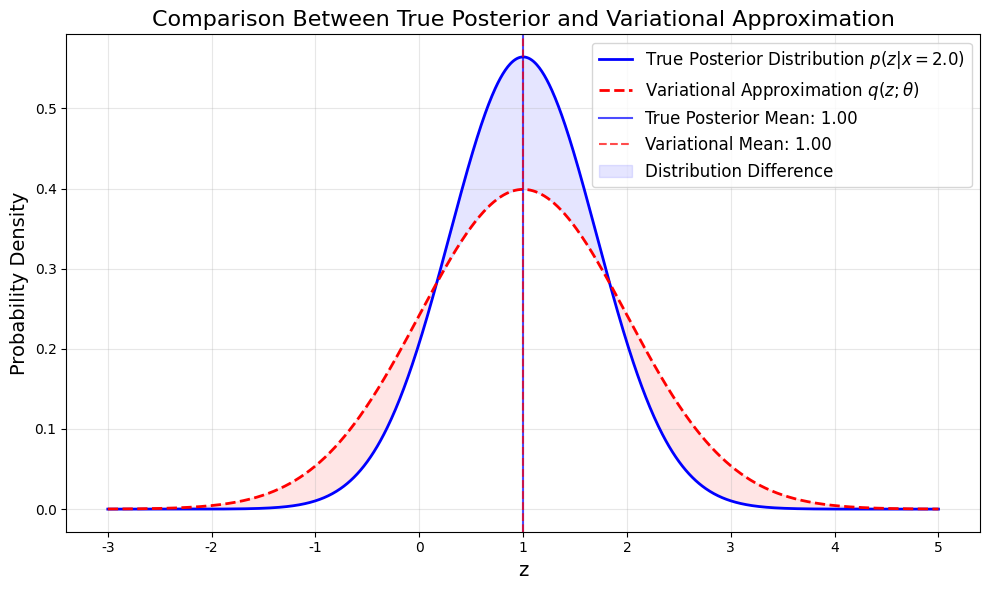

In [11]:
# 第五部分：可视化真实后验与变分近似
# 生成z值
z = np.linspace(-3, 5, 1000)

# 计算概率密度
p_z_given_x = norm.pdf(z, loc=posterior_mean, scale=np.sqrt(posterior_var)) # N(μ=1.00, σ²=0.50)
q_z = norm.pdf(z, loc=variational_mean, scale=np.sqrt(variational_var)) # N(μ=1.00, σ²=1.00)

# 创建图形
plt.figure(figsize=(10, 6))
plt.plot(z, p_z_given_x, 'b-', linewidth=2, label=f'True Posterior Distribution $p(z|x={x_observed})$')
plt.plot(z, q_z, 'r--', linewidth=2, label=f'Variational Approximation $q(z;\\theta)$')

# 标记均值
plt.axvline(x=posterior_mean, color='b', linestyle='-', alpha=0.7, 
            label=f'True Posterior Mean: {posterior_mean:.2f}')
plt.axvline(x=variational_mean, color='r', linestyle='--', alpha=0.7, 
            label=f'Variational Mean: {variational_mean:.2f}')

# 填充差异区域
plt.fill_between(z, p_z_given_x, q_z, where=(p_z_given_x > q_z), 
                 color='blue', alpha=0.1, label='Distribution Difference')
plt.fill_between(z, p_z_given_x, q_z, where=(p_z_given_x <= q_z), 
                 color='red', alpha=0.1)

# 设置图形属性
plt.xlabel('z', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Comparison Between True Posterior and Variational Approximation', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## 数值解法：一维高斯分布的后验近似

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

In [2]:
# 数据和模型参数
x_observed = torch.tensor([2.0])  # 观测值
prior_mean = torch.tensor([0.0])  # 先验均值
prior_var = torch.tensor([1.0])   # 先验方差, p(z) = N(0, 1)
likelihood_var = torch.tensor([1.0])  # 似然函数方差, p(x|z) = N(z, 1)

# 定义网格范围（用于可视化）
z_range = np.linspace(-5, 5, 1000)

In [ ]:
# ========== 第一部分：使用数值积分计算真实后验 ==========
def prior(z):
    """先验分布 p(z) = N(z; prior_mean, prior_var)
    """
    return torch.exp(-0.5 * ((z - prior_mean) ** 2) / prior_var) / torch.sqrt(2 * np.pi * prior_var)

def likelihood(z, x):
    """似然函数 p(x|z) = N(x; z, likelihood_var)
    """
    return torch.exp(-0.5 * ((x - z) ** 2) / likelihood_var) / torch.sqrt(2 * np.pi * likelihood_var)

def unnormalized_posterior(z, x):
    """未归一化的后验分布 p(z|x) ∝ p(x|z)p(z), p(z|x)=p(x|z)p(z)/p(x)
    """
    return likelihood(z, x) * prior(z)

# 计算归一化常数（使用数值积分近似）
z_grid = torch.linspace(-10, 10, 1000) # 生成 -10 到 10 的 1000 个数
dz = z_grid[1] - z_grid[0]
normalization_constant = torch.sum(unnormalized_posterior(z_grid, x_observed)) * dz

# 计算真实后验分布
true_posterior = np.array([unnormalized_posterior(torch.tensor([z]), x_observed).item() / normalization_constant.item() for z in z_range])

In [ ]:
# ========== 第二部分：变分推断（VI）实现 ==========
class VariationalInference(nn.Module):
    def __init__(self):
        super().__init__()
        # 变分参数（初始化为0）
        self.mu = nn.Parameter(torch.tensor([0.0]))
        self.log_sigma = nn.Parameter(torch.tensor([0.0]))
        
    def forward(self, n_samples):
        """从变分分布中采样
        """
        # 重参数化技巧
        epsilon = torch.randn(n_samples, 1)
        sigma = torch.exp(self.log_sigma)
        z = self.mu + sigma * epsilon
        return z
    
    def get_distribution(self):
        """获取变分分布的参数
        """
        return self.mu, torch.exp(self.log_sigma)

def elbo(model, x, n_samples=100):
    """计算ELBO（证据下界），最大化 ELBO
    elbo = E[log p(x|z)] + E[log p(z)] + E[log q(z;\theta)]
    """
    z_samples = model(n_samples) # forward
    mu, sigma = model.get_distribution()
    
    # 1. 重构项（期望对数似然）
    log_likelihood = torch.mean(torch.log(likelihood(z_samples, x))) # p(x|z)
    
    # 2. 先验项（期望对数先验）
    log_prior = torch.mean(torch.log(prior(z_samples))) # p(z)
    
    # 3. 熵项（变分分布的熵）
    entropy = 0.5 * torch.log(2 * np.pi * sigma**2) + 0.5 # 高斯分布的熵
    
    return log_likelihood + log_prior + entropy

# 初始化模型和优化器
model = VariationalInference()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

# 训练循环
elbo_history = []
params_history = []
n_iterations = 2000

for i in tqdm(range(n_iterations), desc="变分优化"):
    # 计算负ELBO（因为PyTorch默认是最小化）
    loss = -elbo(model, x_observed, n_samples=200)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # 记录ELBO和参数
    with torch.no_grad():
        current_elbo = -loss.item()
        mu, sigma = model.get_distribution()
        elbo_history.append(current_elbo)
        params_history.append((mu.item(), sigma.item()))

# 获取最终变分参数
variational_mu, variational_sigma = model.get_distribution()
variational_mu = variational_mu.item()
variational_sigma = variational_sigma.item()

# 计算变分分布在网格上的值
variational_posterior = norm.pdf(z_range, loc=variational_mu, scale=variational_sigma)

变分优化: 100%|██████████| 2000/2000 [00:01<00:00, 1316.13it/s]


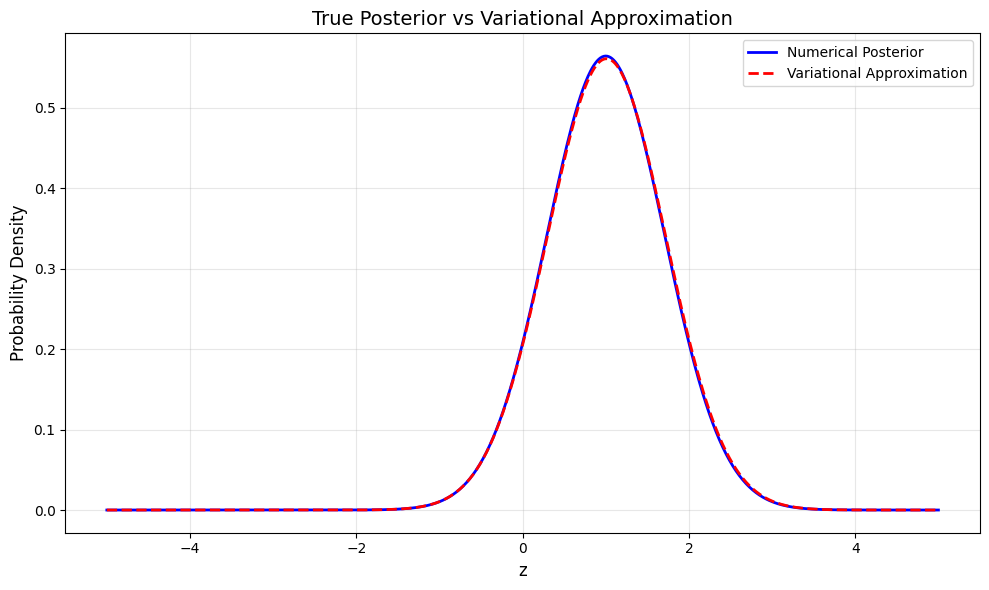

In [ ]:
# 1. 绘制真实后验与变分近似的对比
plt.figure(figsize=(10, 6))
plt.plot(z_range, true_posterior, 'b-', linewidth=2, label='Numerical Posterior')
plt.plot(z_range, variational_posterior, 'r--', linewidth=2, label='Variational Approximation')
plt.xlabel('z', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('True Posterior vs Variational Approximation', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

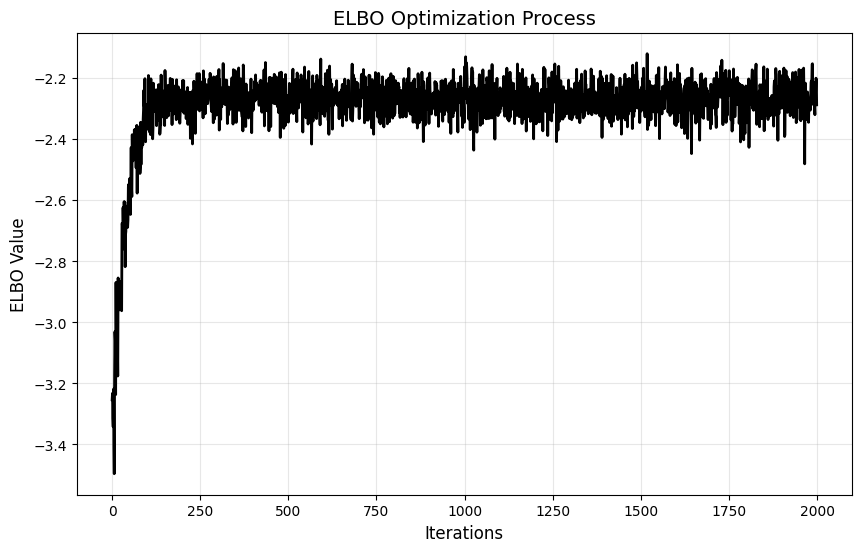

In [ ]:
# 2. 绘制ELBO随迭代的变化, Max ELBO
plt.figure(figsize=(10, 6))
plt.plot(elbo_history, 'k-', linewidth=2)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('ELBO Value', fontsize=12)
plt.title('ELBO Optimization Process', fontsize=14)
plt.grid(True, alpha=0.3)

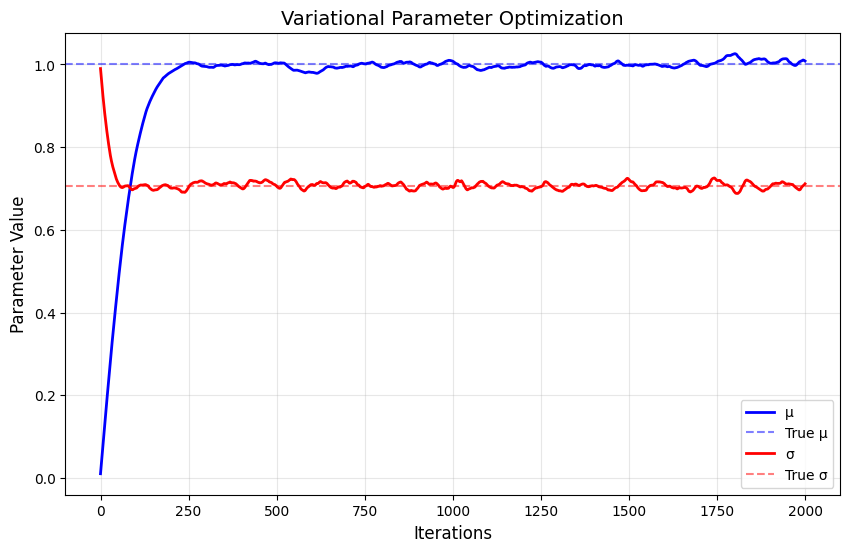

In [8]:
plt.figure(figsize=(10, 6))
mu_history = [p[0] for p in params_history]
sigma_history = [p[1] for p in params_history]
plt.plot(mu_history, 'b-', linewidth=2, label='μ')
plt.axhline(y=1.0, color='b', linestyle='--', alpha=0.5, label='True μ')
plt.plot(sigma_history, 'r-', linewidth=2, label='σ')
plt.axhline(y=np.sqrt(0.5), color='r', linestyle='--', alpha=0.5, label='True σ')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Parameter Value', fontsize=12)
plt.title('Variational Parameter Optimization', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

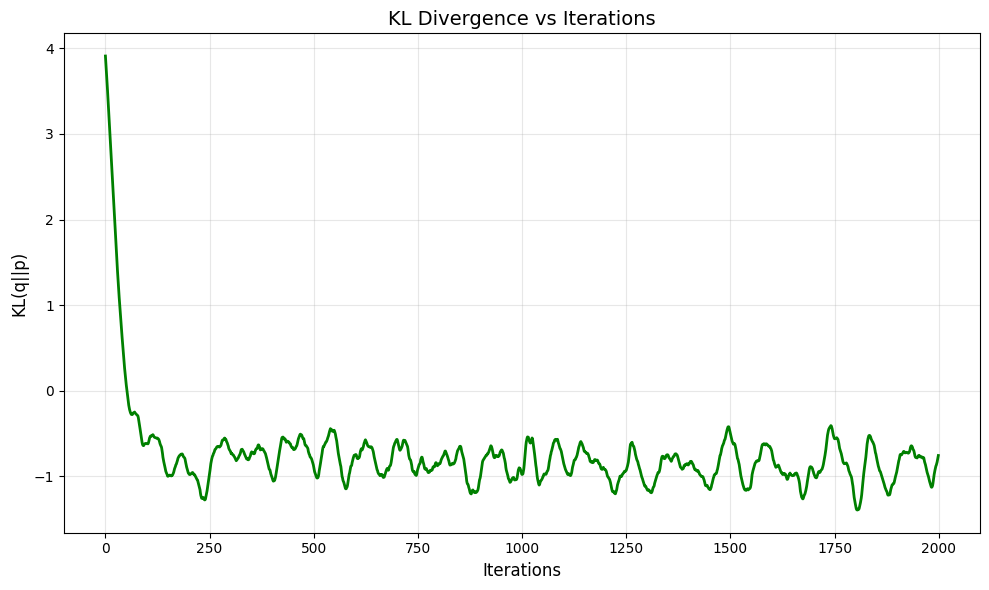

In [9]:
# 4. 计算并可视化KL散度随迭代的变化
plt.figure(figsize=(10, 6))
kl_history = []
for mu, sigma in params_history:
    # 计算当前变分分布与真实后验的KL散度（近似）
    q_dist = norm(loc=mu, scale=sigma)
    kl = np.mean([q_dist.logpdf(z) - np.log(true_posterior[i] + 1e-10) 
                 for i, z in enumerate(z_range)])
    kl_history.append(kl)

plt.plot(kl_history, 'g-', linewidth=2)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('KL(q||p)', fontsize=12)
plt.title('KL Divergence vs Iterations', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 数值解法：一维指数分布的后验近似

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
from tqdm import tqdm

In [15]:
# 数据和模型参数
x_observed = torch.tensor([2.0])  # 观测值
prior_lambda = torch.tensor([1.0])  # 指数分布的率参数 (λ)
likelihood_var = torch.tensor([1.0])  # 似然函数方差

# 定义网格范围（用于可视化）
z_range = np.linspace(0, 5, 1000)  # 指数分布只支持z≥0

In [16]:
# ========== 第一部分：使用数值积分计算真实后验 ==========
def prior(z):
    """指数先验分布 p(z) = Exp(z; λ)"""
    # 当z<0时返回0（指数分布只支持非负z）
    return torch.where(z >= 0, 
                      prior_lambda * torch.exp(-prior_lambda * z), 
                      torch.zeros_like(z))

def likelihood(z, x):
    """似然函数 p(x|z) = N(x; z, likelihood_var)"""
    return torch.exp(-0.5 * ((x - z) ** 2) / likelihood_var) / torch.sqrt(2 * np.pi * likelihood_var)

def unnormalized_posterior(z, x):
    """未归一化的后验分布 p(z|x) ∝ p(x|z)p(z)"""
    return likelihood(z, x) * prior(z)

# 计算归一化常数（使用数值积分近似）
z_grid = torch.linspace(0, 10, 1000)  # 指数分布只考虑z≥0
dz = z_grid[1] - z_grid[0]
normalization_constant = torch.sum(unnormalized_posterior(z_grid, x_observed)) * dz

# 计算真实后验分布
true_posterior = np.array([unnormalized_posterior(torch.tensor([z]), x_observed).item() / normalization_constant.item() for z in z_range])

In [19]:
# ========== 第二部分：变分推断（VI）实现 ==========
class VariationalInference(nn.Module):
    def __init__(self):
        super().__init__()
        # 变分参数（初始化为非负）
        self.mu = nn.Parameter(torch.tensor([1.0]))  # 初始均值设为1（指数分布均值为1/λ=1）
        self.log_sigma = nn.Parameter(torch.tensor([0.0]))  # 对数标准差
        
    def forward(self, n_samples):
        """从变分分布中采样"""
        # 重参数化技巧（使用正态分布作为变分分布）
        epsilon = torch.randn(n_samples, 1)
        sigma = torch.exp(self.log_sigma)
        z = self.mu + sigma * epsilon
        
        # 确保采样值非负（因为指数先验要求z≥0）
        # 这里使用ReLU，但更好的方法是使用对数正态分布等非负分布
        return torch.relu(z)
    
    def get_distribution(self):
        """获取变分分布的参数"""
        return self.mu, torch.exp(self.log_sigma)

def elbo(model, x, n_samples=100):
    """计算ELBO（证据下界）"""
    z_samples = model(n_samples)
    mu, sigma = model.get_distribution()
    
    # 1. 重构项（期望对数似然）
    log_likelihood = torch.mean(torch.log(likelihood(z_samples, x) + 1e-10))
    
    # 2. 先验项（期望对数先验）
    # 对z<0的样本，对数先验设为负无穷（但在采样时已通过ReLU确保z≥0）
    log_prior = torch.mean(torch.log(prior(z_samples) + 1e-10))
    
    # 3. 熵项（变分分布的熵）
    # 注意：这里假设变分分布是正态分布，即使我们应用了ReLU
    entropy = 0.5 * torch.log(2 * np.pi * sigma**2) + 0.5
    
    return log_likelihood + log_prior + entropy

# 初始化模型和优化器
model = VariationalInference()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

# 训练循环
elbo_history = []
params_history = []
n_iterations = 5000

for i in tqdm(range(n_iterations), desc="变分优化"):
    # 计算负ELBO（因为PyTorch默认是最小化）
    loss = -elbo(model, x_observed, n_samples=200)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # 记录ELBO和参数
    with torch.no_grad():
        current_elbo = -loss.item()
        mu, sigma = model.get_distribution()
        elbo_history.append(current_elbo)
        params_history.append((mu.item(), sigma.item()))

# 获取最终变分参数
variational_mu, variational_sigma = model.get_distribution()
variational_mu = variational_mu.item()
variational_sigma = variational_sigma.item()

# 计算变分分布在网格上的值
variational_posterior = norm.pdf(z_range, loc=variational_mu, scale=variational_sigma)

变分优化: 100%|██████████| 5000/5000 [00:03<00:00, 1306.18it/s]


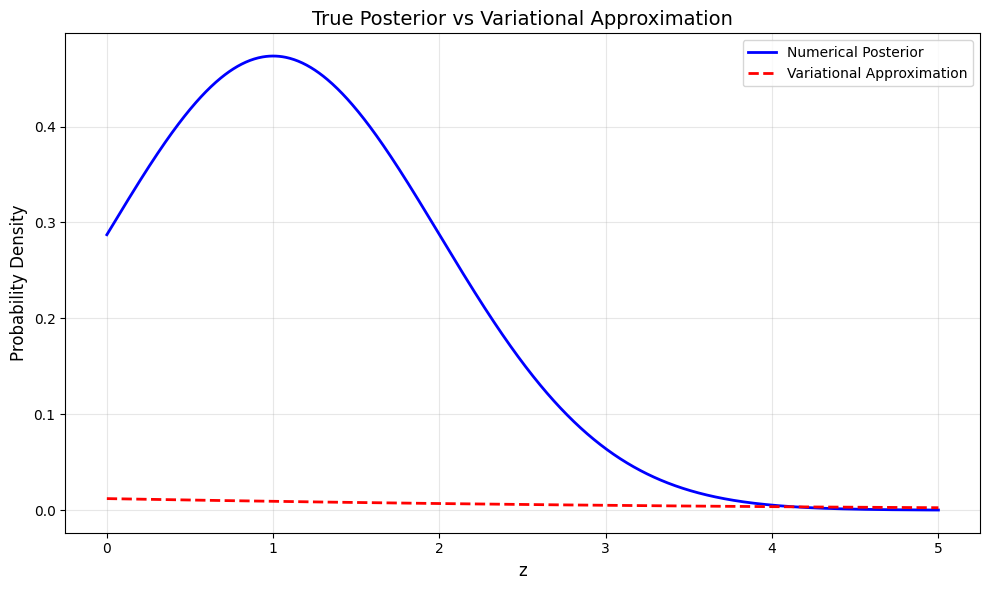

In [20]:
# 绘制真实后验与变分近似的对比
plt.figure(figsize=(10, 6))
plt.plot(z_range, true_posterior, 'b-', linewidth=2, label='Numerical Posterior')
plt.plot(z_range, variational_posterior, 'r--', linewidth=2, label='Variational Approximation')
plt.xlabel('z', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('True Posterior vs Variational Approximation', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()